 [Link for Colab File](https://colab.research.google.com/drive/1IZsI2MLZqZBJkvvXz0JwS644DEKIbnvp)

Dataset Used: UTKFace

Starting Point for the code: [eriklindernoren's cycleGan](https://github.com/eriklindernoren/Keras-GAN/blob/master/cyclegan/cyclegan.py)


The current approach has two cycle gans:


*   AgeGan: Two generators: Old to Young and Young to Old
*   RaceGan: Two generators: White to Black and Black to White
*   GenderGan: Two generators: Male to Female and Female to Male (unsatisfactory results, hence not included)

AgeGan uses 




Other references: 
* [MingwangLin cyclegan-keras](https://github.com/MingwangLin/cyclegan-keras/blob/master/CycleGAN-keras.ipynb)

* [Understanding and Implementing CycleGAN in TensorFlow](https://hardikbansal.github.io/CycleGANBlog/)
* [Face Aging Using Conditional GANs](https://medium.com/towards-artificial-intelligence/face-aging-using-conditional-gans-an-introduction-to-age-cgans-machine-learning-8a4a6a100201)
*  [jiechen2358's FaceAging-by-cycleGAN](https://github.com/jiechen2358/FaceAging-by-cycleGAN)
* [age-gender-estimation](https://github.com/yu4u/age-gender-estimation)
* [hyunbo9's yonsei](https://github.com/hyunbo9/yonsei)




### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Setup

In [2]:
!pip install scipy==1.1.0
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 31.2MB 33.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-utiz5sno
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-utiz5sno
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=a64fc79305c84bac4456f47f7914cabb9cd404b67335e003fa9a979018fc8649
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1llnagx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


### Download Dataset

In [1]:
# !unzip "./drive/My Drive/UTKFace.tar.gz"
!mkdir './datasets'
!tar -xzf "./drive/My Drive/UTKFace.tar.gz" -C "./datasets/"
!mkdir './datasets/trainA'
!mkdir './datasets/trainB'
!mkdir './datasets/testA/'
!mkdir './datasets/testB/'

mkdir: cannot create directory ‘./datasets’: File exists


### Data Preparation

In [0]:
import os
import shutil
count1=0
count2=0
count3=0
files = os.listdir('./datasets/UTKFace/')
for f in files:  
  try:
    gender=int(f.split('_')[1])
    age=int(f.split('_')[0])
    if gender ==0 and age>15:
      count1+=1      
      if count1%6==0:
        shutil.move('./datasets/UTKFace/'+f, './datasets/testA/'+f)  
      else:        
        shutil.move('./datasets/UTKFace/'+f, './datasets/trainA/'+f)
    elif gender==1 and age>15:
      count2+=1
      if count2%6==0:
        shutil.move('./datasets/UTKFace/'+f, './datasets/testB/'+f)
      else:
        shutil.move('./datasets/UTKFace/'+f, './datasets/trainB/'+f)
    else:
      count3+=1
  except:
    pass
print(count1,count2,count3)

10588 9292 3828


### DataLoader

In [0]:
import scipy
import scipy.misc
import imageio
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
#         path = glob('./dataset/%s/%s/*' % (self.dataset_name, data_type))
        path = glob('./datasets/%s/*' % (data_type))
#         print(path)
        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
#             print(img_path)
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%sA/*' % (data_type))
        path_B = glob('./datasets/%sB/*' % (data_type))
#         path_A = glob('./dataset/%s/%sA/*' % (self.dataset_name, data_type))
#         path_B = glob('./dataset/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

### CycleGan for Race

#### Model 1

In [0]:
# 1
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        
        plt.close()

#### Model 2

In [3]:
# 2
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = ReLU()(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*6)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*12)

        # Upsampling
        u1 = deconv2d(d6, d5, self.gf*8)
        u2 = deconv2d(u1, d4, self.gf*6)
        u3 = deconv2d(u2, d3, self.gf*4)
        u4 = deconv2d(u3, d2, self.gf*2)
        u5 = deconv2d(u4, d1, self.gf)
        
#         u1 = deconv2d(d4, d3, self.gf*4)
#         u2 = deconv2d(u1, d2, self.gf*2)
#         u3 = deconv2d(u2, d1, self.gf)

#         u4 = UpSampling2D(size=2)(u3)
        u6 = UpSampling2D(size=2)(u5)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u6)#(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*6)
        d5 = d_layer(d3, self.df*8)
        d6 = d_layer(d3, self.df*12)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d6)#(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./drive/My Drive/EIP3/img3/%d_%d.png" % ( epoch, batch_i))
        plt.close()

Using TensorFlow backend.


#### Train

In [0]:
raceGan = CycleGAN()
raceGan.train(epochs=50, batch_size=1, sample_interval=200)

#### Initialize and Load Weights

In [4]:
# raceGan1 = CycleGAN()
# raceGan1.d_A.load_weights("./drive/My Drive/EIP3GLOVIA/gans1/d_A.h5")
# raceGan1.d_B.load_weights("./drive/My Drive/EIP3GLOVIA/gans1/d_B.h5")
# raceGan1.g_AB.load_weights("./drive/My Drive/EIP3GLOVIA/gans1/g_AB.h5")
# raceGan1.g_BA.load_weights("./drive/My Drive/EIP3GLOVIA/gans1/g_BA.h5")
# raceGan1.combined.load_weights("./drive/My Drive/EIP3GLOVIA/gans1/combined.h5")

raceGan2 = CycleGAN()
raceGan2.d_A.load_weights("./drive/My Drive/EIP3GLOVIA/gans2/d_A.h5")
raceGan2.d_B.load_weights("./drive/My Drive/EIP3GLOVIA/gans2/d_B.h5")
raceGan2.g_AB.load_weights("./drive/My Drive/EIP3GLOVIA/gans2/g_AB.h5")
raceGan2.g_BA.load_weights("./drive/My Drive/EIP3GLOVIA/gans2/g_BA.h5")
raceGan2.combined.load_weights("./drive/My Drive/EIP3GLOVIA/gans2/combined.h5")

W0825 12:52:28.049073 140428938344320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 12:52:28.050408 140428938344320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 12:52:28.055293 140428938344320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 12:52:28.523656 140428938344320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 12:52:28.774980 140428938344320 deprecation_wrappe

#### Model Comparision

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


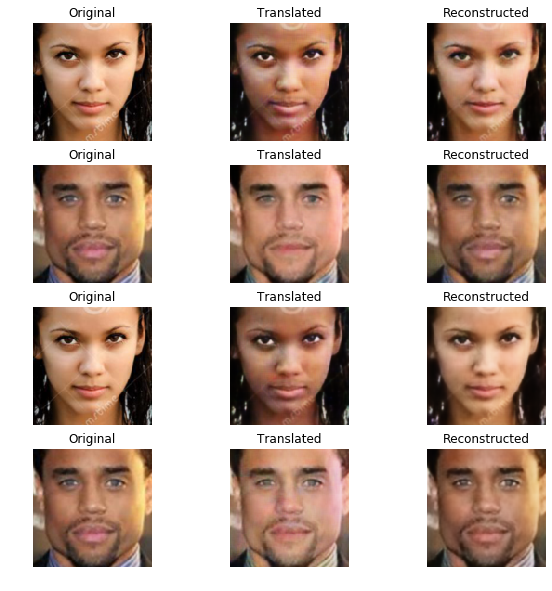

In [198]:
findClassA=findClassB=True
path = glob('./datasets/UTKFace/*')
while(findClassA | findClassB):
  imgpath = np.random.choice(path, size=1)
  race = str(imgpath).split('/')[-1].split('_')[2]
  if findClassA and race=='0':
    imgs_A=readImg(imgpath)
    findClassA=False
  if findClassB and race=='1':
    imgs_B=readImg(imgpath)
    findClassB=False
  

fake1_B = raceGan1.g_AB.predict(imgs_A)
fake1_A = raceGan1.g_BA.predict(imgs_B)
reconstr1_A = raceGan1.g_BA.predict(fake1_B)
reconstr1_B = raceGan1.g_AB.predict(fake1_A)

fake2_B = raceGan2.g_AB.predict(imgs_A)
fake2_A = raceGan2.g_BA.predict(imgs_B)
reconstr2_A = raceGan2.g_BA.predict(fake2_B)
reconstr2_B = raceGan2.g_AB.predict(fake2_A)

r=4
c=3
gen_imgs = np.concatenate([imgs_A, fake1_B, reconstr1_A, imgs_B, fake1_A, reconstr1_B, imgs_A, fake2_B, reconstr2_A, imgs_B, fake2_A, reconstr2_B])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.show()

plt.close()

**Conclusion**: In white to black, apart from changing the skin tone, the faces seem to have increased warmth or a pale apperance. If the person is wearning some makeup, that is also reduced. But the sharpness of image stays intact. In case of black to white, the model makes the skin tone lighter and also adds an overall pink hue.  
Model 2 produces slightly better results than model 1


### CycleGan for Age

#### Model 1

In [0]:
# 1,2
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./drive/My Drive/EIP3SNU/img2 (1)/%d_%d.png" % ( epoch, batch_i))
        plt.close()

#### Model 2

In [0]:
# 3
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = ReLU()(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*6)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*12)

        # Upsampling
        u1 = deconv2d(d6, d5, self.gf*8)
        u2 = deconv2d(u1, d4, self.gf*6)
        u3 = deconv2d(u2, d3, self.gf*4)
        u4 = deconv2d(u3, d2, self.gf*2)
        u5 = deconv2d(u4, d1, self.gf)
        
#         u1 = deconv2d(d4, d3, self.gf*4)
#         u2 = deconv2d(u1, d2, self.gf*2)
#         u3 = deconv2d(u2, d1, self.gf)

#         u4 = UpSampling2D(size=2)(u3)
        u6 = UpSampling2D(size=2)(u5)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u6)#(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*6)
        d5 = d_layer(d3, self.df*8)
        d6 = d_layer(d3, self.df*12)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d6)#(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./drive/My Drive/EIP3SNU/img3/%d_%d.png" % ( epoch, batch_i))
        plt.close()

#### Initialize and Load Weights

In [0]:
# ageGan1 = CycleGAN()
# ageGan1.d_A.load_weights("./drive/My Drive/EIP3SNU/gans1/d_A.h5")
# ageGan1.d_B.load_weights("./drive/My Drive/EIP3SNU/gans1/d_B.h5")
# ageGan1.g_AB.load_weights("./drive/My Drive/EIP3SNU/gans1/g_AB.h5")
# ageGan1.g_BA.load_weights("./drive/My Drive/EIP3SNU/gans1/g_BA.h5")
# ageGan1.combined.load_weights("./drive/My Drive/EIP3SNU/gans1/combined.h5")

ageGan2 = CycleGAN()
ageGan2.d_A.load_weights("./drive/My Drive/EIP3SNU/gans2/d_A.h5")
ageGan2.d_B.load_weights("./drive/My Drive/EIP3SNU/gans2/d_B.h5")
ageGan2.g_AB.load_weights("./drive/My Drive/EIP3SNU/gans2/g_AB.h5")
ageGan2.g_BA.load_weights("./drive/My Drive/EIP3SNU/gans2/g_BA.h5")
ageGan2.combined.load_weights("./drive/My Drive/EIP3SNU/gans2/combined.h5")

# ageGan3 = CycleGAN()
# ageGan3.d_A.load_weights("./drive/My Drive/EIP3SNU/gans3/d_A.h5")
# ageGan3.d_B.load_weights("./drive/My Drive/EIP3SNU/gans3/d_B.h5")
# ageGan3.g_AB.load_weights("./drive/My Drive/EIP3SNU/gans3/g_AB.h5")
# ageGan3.g_BA.load_weights("./drive/My Drive/EIP3SNU/gans3/g_BA.h5")
# ageGan3.combined.load_weights("./drive/My Drive/EIP3SNU/gans3/combined.h5")

#### Model Comparision

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


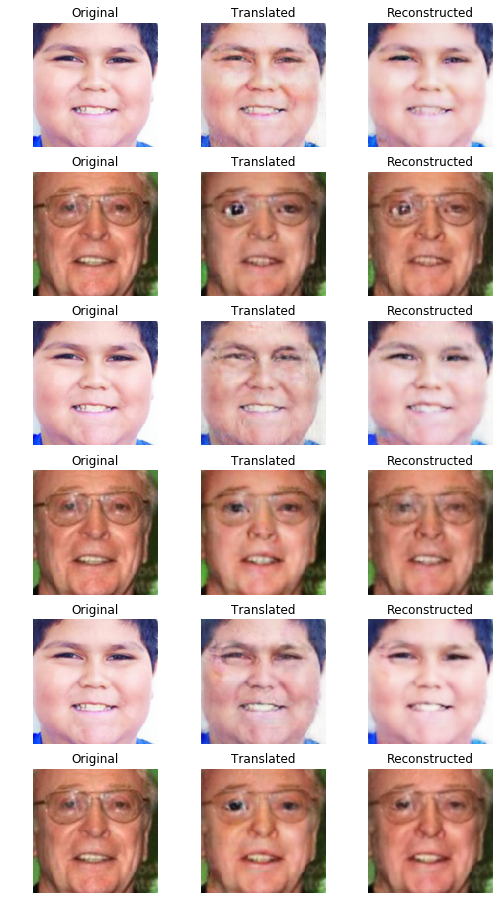

In [109]:
findClassA=findClassB=True
path = glob('./datasets/UTKFace/*')
while(findClassA | findClassB):
  imgpath = np.random.choice(path, size=1)
  age = int(str(imgpath).split('/')[-1].split('_')[0])
  if findClassA and age>10 and age<25:
    imgs_A=readImg(imgpath)
    findClassA=False
    continue
  if findClassB and age>25:
    imgs_B=readImg(imgpath)
    findClassB=False
  

fake1_B = ageGan1.g_AB.predict(imgs_A)
fake1_A = ageGan1.g_BA.predict(imgs_B)
reconstr1_A = ageGan1.g_BA.predict(fake1_B)
reconstr1_B = ageGan1.g_AB.predict(fake1_A)

fake2_B = ageGan2.g_AB.predict(imgs_A)
fake2_A = ageGan2.g_BA.predict(imgs_B)
reconstr2_A = ageGan2.g_BA.predict(fake2_B)
reconstr2_B = ageGan2.g_AB.predict(fake2_A)

fake3_B = ageGan3.g_AB.predict(imgs_A)
fake3_A = ageGan3.g_BA.predict(imgs_B)
reconstr3_A = ageGan3.g_BA.predict(fake3_B)
reconstr3_B = ageGan3.g_AB.predict(fake3_A)

r=6
c=3
gen_imgs = np.concatenate([imgs_A, fake1_B, reconstr1_A, imgs_B, fake1_A, reconstr1_B, imgs_A, fake2_B, reconstr2_A, imgs_B, fake2_A, reconstr2_B, imgs_A, fake3_B, reconstr3_A, imgs_B, fake3_A, reconstr3_B])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c, figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.subplots_adjust(wspace=-0.7)
plt.show()

plt.close()

**Conclusion**: Young to Old model adds some noise on the darker areas on face giving an appearance of wrinkles. It also decreases the brightness and makes the overall face look dull. In case of Old to Young, a smothened skin with reduced wrinkles and enlargement of pupils is observed. It also tries to remove the eye glasses but fails in that. Instead the shadow effect of glasses on face gets diminished.  
Model 2 seems to have better results


### CycleGan for Gender

#### Model 1

In [0]:
# 1
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./drive/My Drive/EIP3SNU/img2 (1)/%d_%d.png" % ( epoch, batch_i))
        plt.close()

#### Model 2

In [0]:
# 2
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'        
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = ReLU()(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*6)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*12)

        # Upsampling
        u1 = deconv2d(d6, d5, self.gf*8)
        u2 = deconv2d(u1, d4, self.gf*6)
        u3 = deconv2d(u2, d3, self.gf*4)
        u4 = deconv2d(u3, d2, self.gf*2)
        u5 = deconv2d(u4, d1, self.gf)
        
#         u1 = deconv2d(d4, d3, self.gf*4)
#         u2 = deconv2d(u1, d2, self.gf*2)
#         u3 = deconv2d(u2, d1, self.gf)

#         u4 = UpSampling2D(size=2)(u3)
        u6 = UpSampling2D(size=2)(u5)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u6)#(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*6)
        d5 = d_layer(d3, self.df*8)
        d6 = d_layer(d3, self.df*12)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d6)#(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('dataset/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('dataset/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./drive/My Drive/EIP3/img2/%d_%d.png" % ( epoch, batch_i))
        plt.close()

#### Train and Save Weights

In [0]:
genderGan = CycleGAN()
genderGan.train(epochs=50, batch_size=1, sample_interval=200)

In [0]:
genderGan.d_A.save_weights("./drive/My Drive/EIP3/gans3/d_A.h5")
genderGan.d_B.save_weights("./drive/My Drive/EIP3/gans3/d_B.h5")
genderGan.g_AB.save_weights("./drive/My Drive/EIP3/gans3/g_AB.h5")
genderGan.g_BA.save_weights("./drive/My Drive/EIP3/gans3/g_BA.h5")
genderGan.combined.save_weights("./drive/My Drive/EIP3/gans3/combined.h5")

#### Initialize and Load Weights

In [0]:
genderGan1 = CycleGAN()
genderGan1.d_A.load_weights("./drive/My Drive/EIP3MAIN/gans1/d_A.h5")
genderGan1.d_B.load_weights("./drive/My Drive/EIP3MAIN/gans1/d_B.h5")
genderGan1.g_AB.load_weights("./drive/My Drive/EIP3MAIN/gans1/g_AB.h5")
genderGan1.g_BA.load_weights("./drive/My Drive/EIP3MAIN/gans1/g_BA.h5")
genderGan1.combined.load_weights("./drive/My Drive/EIP3MAIN/gans1/combined.h5")

# genderGan2 = CycleGAN()
# genderGan2.d_A.load_weights("./drive/My Drive/EIP3MAIN/gans2/d_A.h5")
# genderGan2.d_B.load_weights("./drive/My Drive/EIP3MAIN/gans2/d_B.h5")
# genderGan2.g_AB.load_weights("./drive/My Drive/EIP3MAIN/gans2/g_AB.h5")
# genderGan2.g_BA.load_weights("./drive/My Drive/EIP3MAIN/gans2/g_BA.h5")
# genderGan2.combined.load_weights("./drive/My Drive/EIP3MAIN/gans2/combined.h5")

#### Model Comparision

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


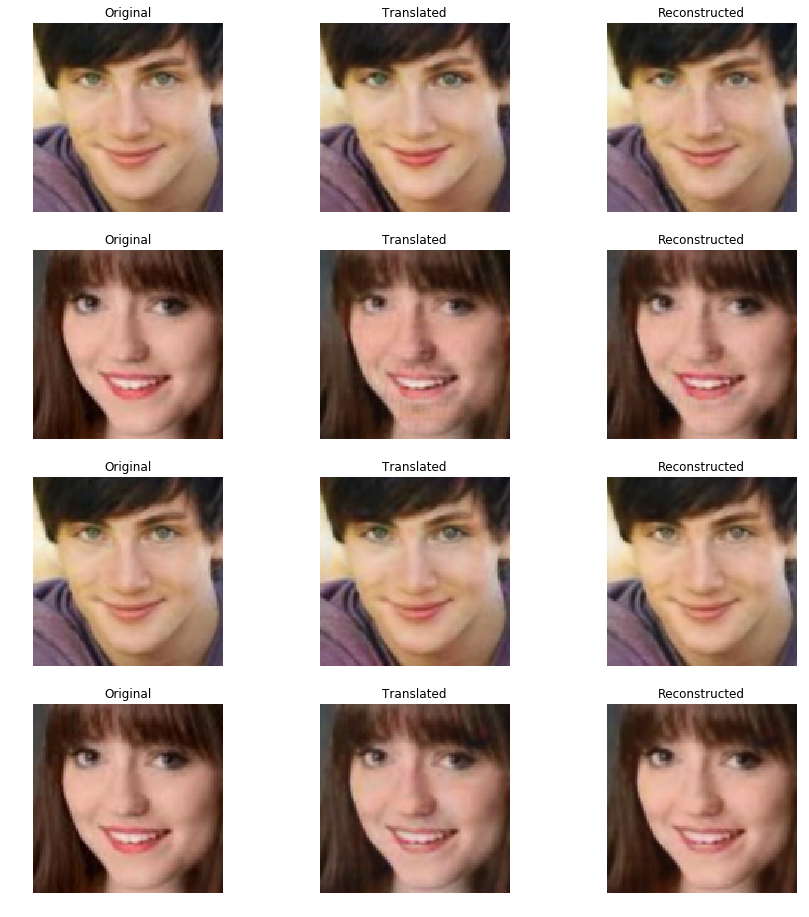

In [150]:
findClassA=findClassB=True
path = glob('./datasets/UTKFace/*')
while(findClassA | findClassB):
  imgpath = np.random.choice(path, size=1)
  gender = int(str(imgpath).split('/')[-1].split('_')[1])
  if findClassA and gender==0:
    imgs_A=readImg(imgpath)
    findClassA=False
    continue
  if findClassB and gender==1:
    imgs_B=readImg(imgpath)
    findClassB=False
  

fake1_B = genderGan1.g_AB.predict(imgs_A)
fake1_A = genderGan1.g_BA.predict(imgs_B)
reconstr1_A = genderGan1.g_BA.predict(fake1_B)
reconstr1_B = genderGan1.g_AB.predict(fake1_A)

fake2_B = genderGan2.g_AB.predict(imgs_A)
fake2_A = genderGan2.g_BA.predict(imgs_B)
reconstr2_A = genderGan2.g_BA.predict(fake2_B)
reconstr2_B = genderGan2.g_AB.predict(fake2_A)


r=4
c=3
gen_imgs = np.concatenate([imgs_A, fake1_B, reconstr1_A, imgs_B, fake1_A, reconstr1_B, imgs_A, fake2_B, reconstr2_A, imgs_B, fake2_A, reconstr2_B])

# Rescale imgenders 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c, figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.subplots_adjust(wspace=-0.1)
plt.show()

plt.close()

**Conclusion**: Though none of the models are producing desirable results, but they do add subtle beard/moustache in case of female to male. For male to female the slight brightening of lips, little shadow below eyes and smoothened skin is observed.  
Model 1 seems to have better results.


## Results

In [0]:
def readImg(paths):
  imgs=[]
  for path in paths:
    img = scipy.misc.imread(path, mode='RGB').astype(np.float)
    img = scipy.misc.imresize(img, (128,128))
    imgs.append(img)
  imgs = np.array(imgs)/127.5 - 1.
  return imgs

### Combining Models *1* (out of three) at a time

#### Gender

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


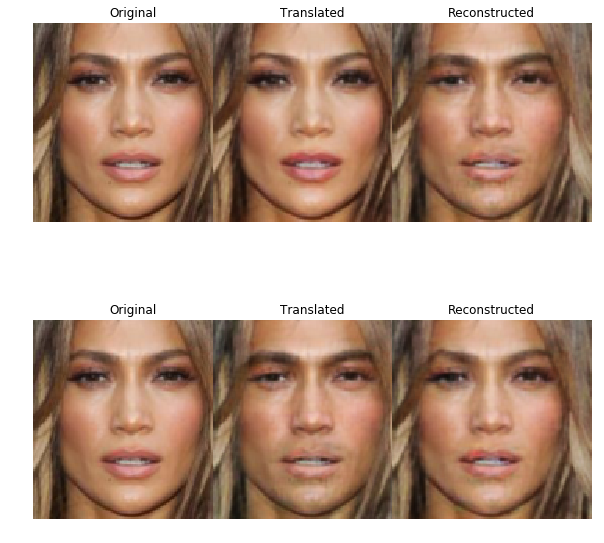

In [222]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)
fake_B = genderGan1.g_AB.predict(imgs_A)
fake_A = genderGan1.g_BA.predict(imgs_A)
# Translate back to original domain
reconstr_A = genderGan1.g_BA.predict(fake_B)
reconstr_B = genderGan1.g_AB.predict(fake_A)

r=2
c=3
gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_A, fake_A, reconstr_B])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.subplots_adjust(wspace=-0.1)
plt.show()
plt.close()

#### Age

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


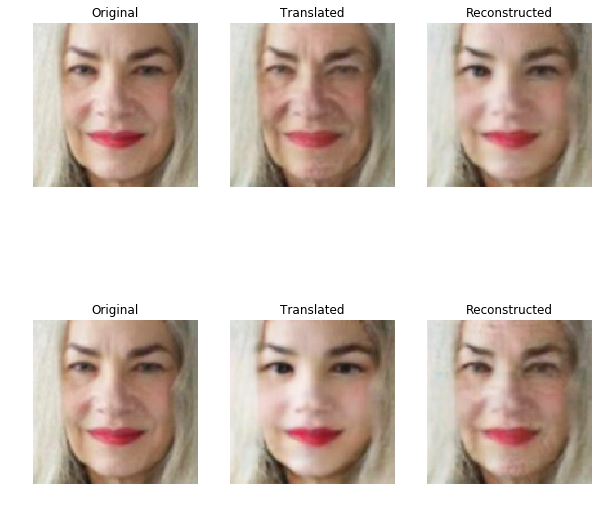

In [296]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)
fake_B = ageGan2.g_AB.predict(imgs_A)
fake_A = ageGan2.g_BA.predict(imgs_A)
# Translate back to original domain
reconstr_A = ageGan2.g_BA.predict(fake_B)
reconstr_B = ageGan2.g_AB.predict(fake_A)

r=2
c=3
gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_A, fake_A, reconstr_B])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c,figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

#### Race

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


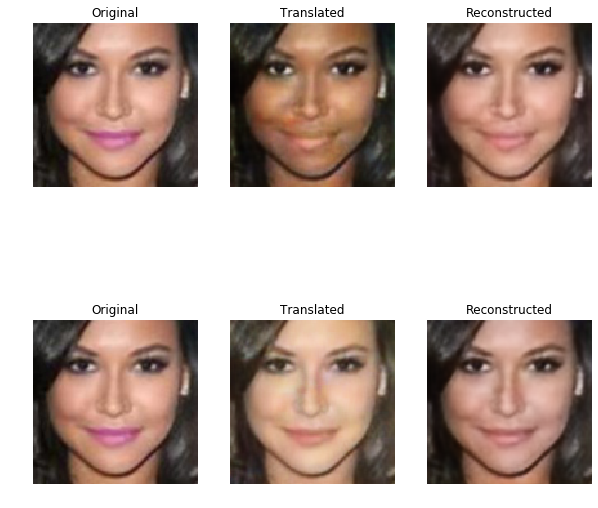

In [298]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)
fake_B = raceGan2.g_AB.predict(imgs_A)
fake_A = raceGan2.g_BA.predict(imgs_A)
# Translate back to original domain
reconstr_A = raceGan2.g_BA.predict(fake_B)
reconstr_B = raceGan2.g_AB.predict(fake_A)

r=2
c=3
gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_A, fake_A, reconstr_B])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(r, c,figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

### Combining Models *2* (out of 3) at a time

#### Race=> Gender and Race=>Age

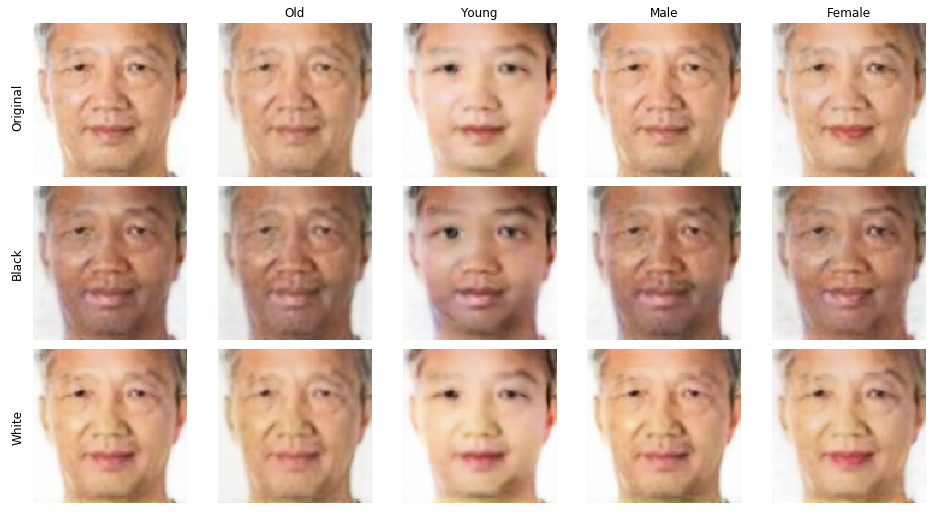

In [102]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_Black_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black)
fakeRace_Black_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black)

fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)
fakeRace_White_Gender_Male = genderGan1.g_BA.predict(fakeRace_White)
fakeRace_White_Gender_Female = genderGan1.g_AB.predict(fakeRace_White)


r=3
c=5
gen_imgs = np.concatenate([imgs_A,         fakeAge_Old,            fakeAge_Young,            fakeGender_Male,            fakeGender_Female, 
                           fakeRace_Black, fakeRace_Black_Age_Old, fakeRace_Black_Age_Young, fakeRace_Black_Gender_Male, fakeRace_Black_Gender_Female,
                           fakeRace_White, fakeRace_White_Age_Old, fakeRace_White_Age_Young, fakeRace_White_Gender_Male, fakeRace_White_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Original', 'Old', 'Young', 'Male','Female']
titlesY = ['Original', 'Black', 'White']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[0, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


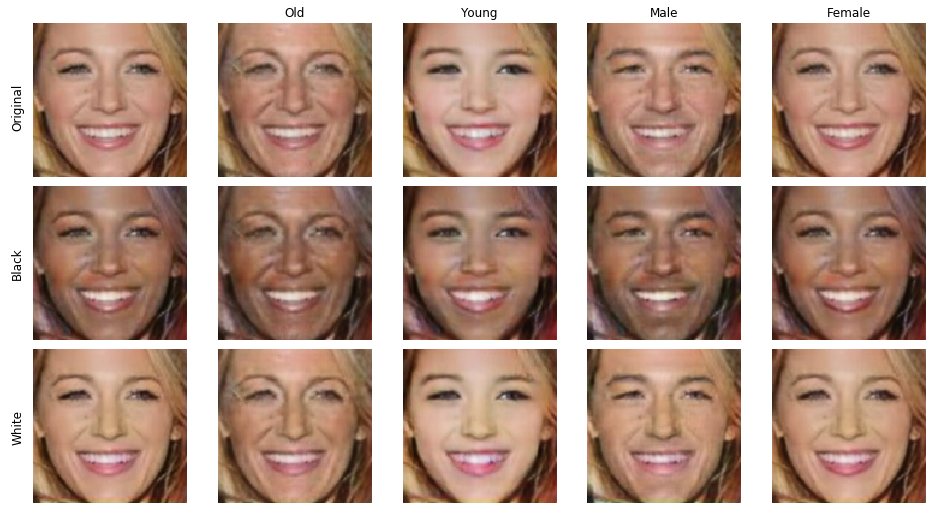

In [31]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_Black_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black)
fakeRace_Black_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black)

fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)
fakeRace_White_Gender_Male = genderGan1.g_BA.predict(fakeRace_White)
fakeRace_White_Gender_Female = genderGan1.g_AB.predict(fakeRace_White)


r=3
c=5
gen_imgs = np.concatenate([imgs_A,         fakeAge_Old,            fakeAge_Young,            fakeGender_Male,            fakeGender_Female, 
                           fakeRace_Black, fakeRace_Black_Age_Old, fakeRace_Black_Age_Young, fakeRace_Black_Gender_Male, fakeRace_Black_Gender_Female,
                           fakeRace_White, fakeRace_White_Age_Old, fakeRace_White_Age_Young, fakeRace_White_Gender_Male, fakeRace_White_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Original', 'Old', 'Young', 'Male','Female']
titlesY = ['Original', 'Black', 'White']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[0, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()

### Combining Models *3* (out of 3) at a time
#### Race=> Age=>Gender

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


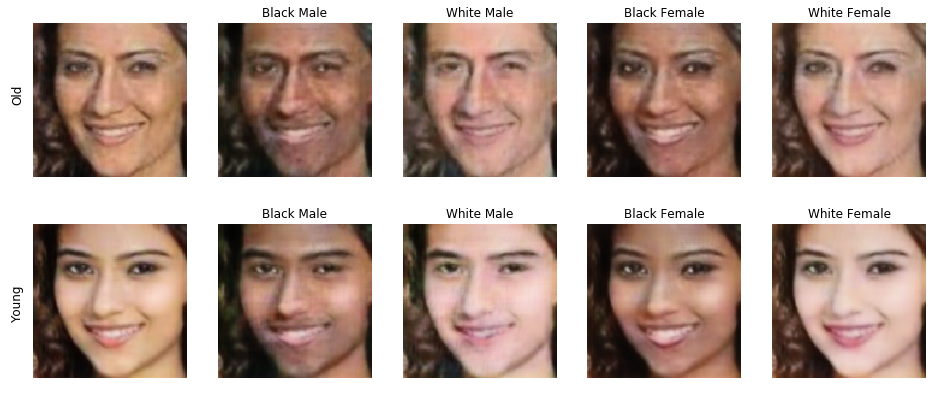

['./datasets/UTKFace/20_1_3_20170104222034231.jpg.chip.jpg']


In [127]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)



r=2
c=5
gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()
print(path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


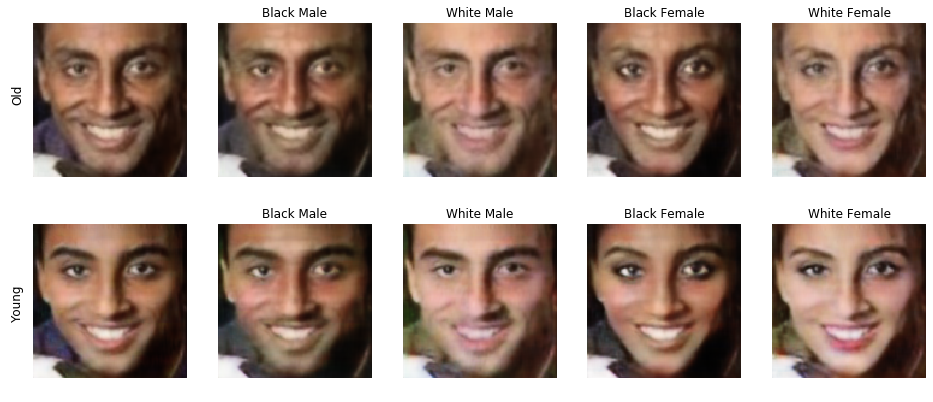

In [119]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)



r=2
c=5
gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()

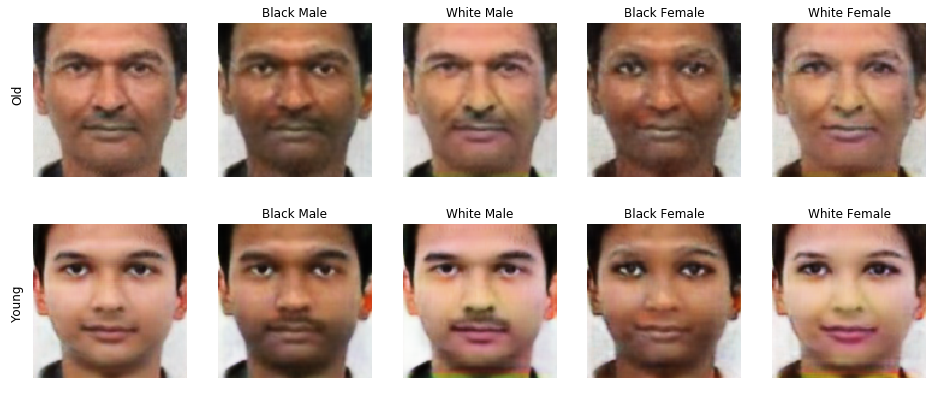

In [111]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)



r=2
c=5
gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


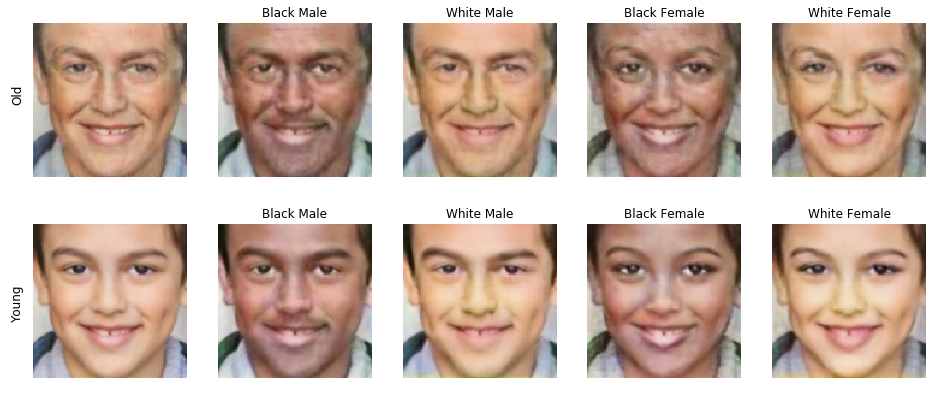

['./datasets/UTKFace/11_0_0_20170110225327724.jpg.chip.jpg']


In [128]:
path = glob('./datasets/UTKFace/*')
path = np.random.choice(path, size=1)
imgs_A=readImg(path)

fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
fakeRace_White = raceGan2.g_BA.predict(imgs_A)

fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)



r=2
c=5
gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(16,16))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titlesX[j])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=-0.7)
plt.show()
plt.close()
print(path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


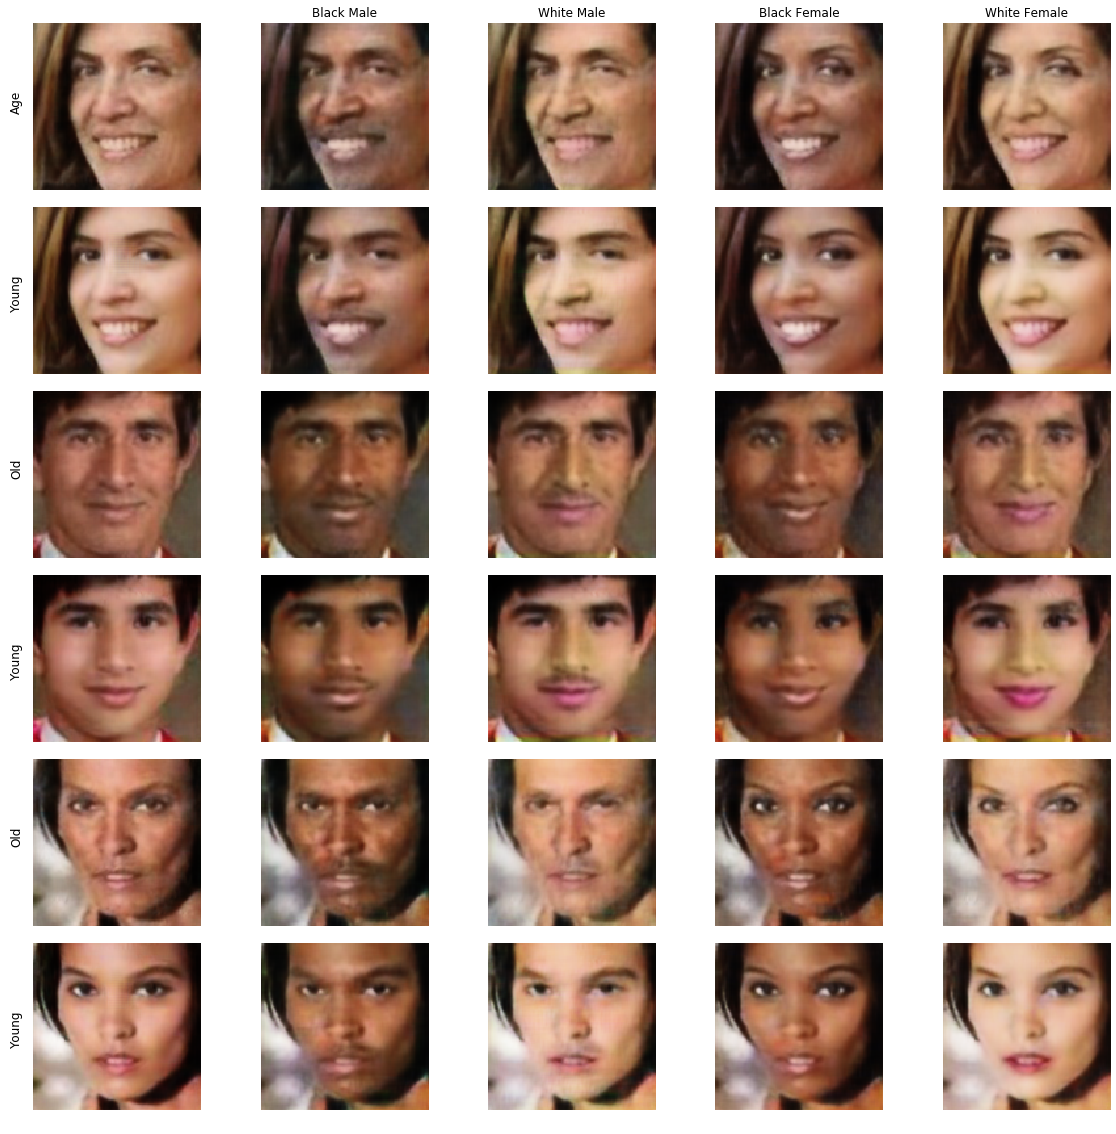

In [241]:
gen_imgs =[]
samples=3
for sample in range(samples):
  path = glob('./datasets/UTKFace/*')
  path = np.random.choice(path, size=1)
  imgs_A=readImg(path)
  imgs_A=readImg(paths[sample])

  fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
  fakeRace_White = raceGan2.g_BA.predict(imgs_A)

  fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
  fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

  fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
  fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

  fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
  fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
  fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
  fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

  fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
  fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
  fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
  fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
  fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
  fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
  fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
  fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)
  if len(gen_imgs)==0:
    gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
  fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])
  else:
    gen_imgs = np.concatenate([gen_imgs, fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
  fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])
#   print(path)

gen_imgs = 0.5 * gen_imgs + 0.5
r=2*k
c=5
titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(20,20))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[0, j].set_title(titlesX[j%5])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i%2], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()
plt.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


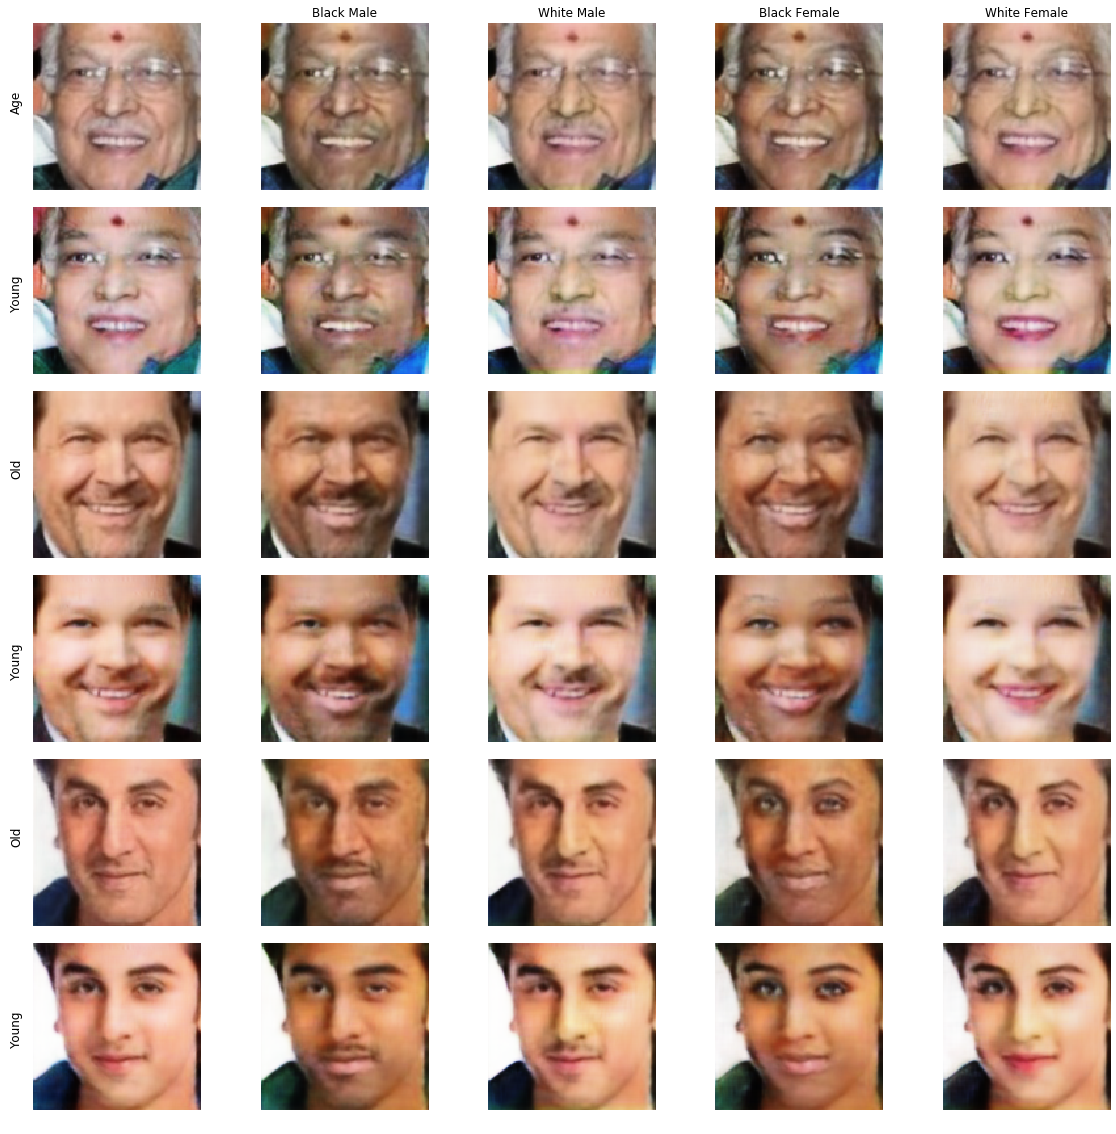

In [244]:
gen_imgs =[]
samples=3
for sample in range(samples):
  path = glob('./datasets/UTKFace/*')
  path = np.random.choice(path, size=1)
  imgs_A=readImg(path)
  imgs_A=readImg(paths[sample])
  fakeRace_Black = raceGan2.g_AB.predict(imgs_A)
  fakeRace_White = raceGan2.g_BA.predict(imgs_A)

  fakeAge_Old = ageGan2.g_AB.predict(imgs_A)
  fakeAge_Young = ageGan2.g_BA.predict(imgs_A)

  fakeGender_Male = genderGan1.g_BA.predict(imgs_A)
  fakeGender_Female = genderGan1.g_AB.predict(imgs_A)

  fakeRace_Black_Age_Old = ageGan2.g_AB.predict(fakeRace_Black)
  fakeRace_Black_Age_Young = ageGan2.g_BA.predict(fakeRace_Black)
  fakeRace_White_Age_Old = ageGan2.g_AB.predict(fakeRace_White)
  fakeRace_White_Age_Young = ageGan2.g_BA.predict(fakeRace_White)

  fakeRace_Black_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Old)
  fakeRace_Black_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Old)
  fakeRace_Black_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_Black_Age_Young)
  fakeRace_Black_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_Black_Age_Young)
  fakeRace_White_Age_Old_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Old)
  fakeRace_White_Age_Old_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Old)
  fakeRace_White_Age_Young_Gender_Male = genderGan1.g_BA.predict(fakeRace_White_Age_Young)
  fakeRace_White_Age_Young_Gender_Female = genderGan1.g_AB.predict(fakeRace_White_Age_Young)
  if len(gen_imgs)==0:
    gen_imgs = np.concatenate([fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
  fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])
  else:
    gen_imgs = np.concatenate([gen_imgs, fakeAge_Old, fakeRace_Black_Age_Old_Gender_Male, fakeRace_White_Age_Old_Gender_Male, fakeRace_Black_Age_Old_Gender_Female,	fakeRace_White_Age_Old_Gender_Female,
  fakeAge_Young, fakeRace_Black_Age_Young_Gender_Male,	fakeRace_White_Age_Young_Gender_Male, fakeRace_Black_Age_Young_Gender_Female,	fakeRace_White_Age_Young_Gender_Female])

gen_imgs = 0.5 * gen_imgs + 0.5
r=2*k
c=5
titlesX = ['Age','Black Male', 'White Male', 'Black Female', 'White Female']
titlesY = ['Old', 'Young']

fig, axs = plt.subplots(r, c,figsize=(20,20))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[0, j].set_title(titlesX[j%5])
        axs[i,j].axis('off')
        axs[i,0].set_title(titlesY[i%2], rotation='vertical',x=-0.1,y=0.5)
        cnt += 1
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()
plt.close()
